In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## data loading

In [2]:
long50Short300 = pd.read_pickle('ivdiffDown10.pkl')
long300Short50 = pd.read_pickle('ivdiffUp90.pkl')

etf50optPrice = pd.read_pickle('data\option\etf50Opt.pkl')
etf300optPrice = pd.read_pickle('data\option\etf300Opt.pkl')

etf50OptRisk = pd.read_pickle('data\option\etf50Risk.pkl')
etf300OptRisk = pd.read_pickle('data\option\etf300Risk.pkl')

## long50Short300

### 未考虑持有期内的波动

In [3]:
dailyPofit = pd.DataFrame()
tradeInfo = pd.DataFrame()
totalholdingPeriod = 0
for index, row in long50Short300.iterrows():
    # 选出对应日期的etf50和etf300的期权价格
    etf50OptCode = row['OptCode50']
    etf300OptCode = row['OptCode300']
    inDate = row['inDate']
    outDate = row['outDate'].strftime('%Y-%m-%d')
    etf50OptPriceIn = etf50optPrice.loc[(etf50optPrice['datetime'] == inDate)&(etf50optPrice['optionCode'] == etf50OptCode), 'close'].values[0]
    etf50OptPriceOut = etf50optPrice.loc[(etf50optPrice['datetime'] == outDate)&(etf50optPrice['optionCode'] == etf50OptCode), 'close'].values[0]
    etf300OptPriceIn = etf300optPrice.loc[(etf300optPrice['datetime'] == inDate)&(etf300optPrice['optionCode'] == etf300OptCode), 'close'].values[0]
    etf300OptPriceOut = etf300optPrice.loc[(etf300optPrice['datetime'] == outDate)&(etf300optPrice['optionCode'] == etf300OptCode), 'close'].values[0]

    inDelta50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == inDate)&(etf50OptRisk['optionCode'] == etf50OptCode), 'delta'].values[0]
    inUnd50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == inDate)&(etf50OptRisk['optionCode'] == etf50OptCode), 'underlying_price'].values[0]
    inDelta300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == inDate)&(etf300OptRisk['optionCode'] == etf300OptCode), 'delta'].values[0]
    inUnd300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == inDate)&(etf300OptRisk['optionCode'] == etf300OptCode), 'underlying_price'].values[0]

    cashDelta50 = inDelta50 * inUnd50
    cashDelta300 = inDelta300 * inUnd300

    share300 = -10000
    share50 = abs(share300 * cashDelta300 / cashDelta50)

    # 计算收益
    profit = share50 * (etf50OptPriceOut - etf50OptPriceIn) + share300 * (etf300OptPriceOut - etf300OptPriceIn)
    # 交易成本结算
    commission = 2 * 1.7 * (abs(share50) + abs(share300)) / 10000
    slppage = 2 * 0.0001 * 0 * (abs(share50) + abs(share300))

    holdingPeriod = (pd.to_datetime(outDate) - pd.to_datetime(inDate)).days
    totalholdingPeriod += holdingPeriod

    print('date: ', outDate, 'profit: ', profit,'holding period', holdingPeriod)
    dailyPofit = pd.concat([dailyPofit, pd.DataFrame({'date': [outDate], 'profit': [profit-commission-slppage]})], ignore_index=True)

dailyProfit = dailyPofit.groupby('date').sum().reset_index()

date:  2020-03-09 profit:  177.89012897537026 holding period 7
date:  2020-03-09 profit:  218.47257014776096 holding period 6
date:  2020-03-09 profit:  159.37576155191294 holding period 5
date:  2020-03-09 profit:  107.92488388257584 holding period 4
date:  2020-03-16 profit:  282.2216562621825 holding period 3
date:  2020-03-20 profit:  348.39552727631286 holding period 1
date:  2020-05-12 profit:  -268.65611475212404 holding period 14
date:  2020-05-12 profit:  44.93625281742365 holding period 4
date:  2020-06-24 profit:  -16.965954359556065 holding period 5
date:  2020-06-24 profit:  77.63776440536239 holding period 2
date:  2020-08-04 profit:  217.49893170504618 holding period 4
date:  2020-08-10 profit:  236.57534595190265 holding period 5
date:  2020-09-24 profit:  36.5220003679874 holding period 1
date:  2020-10-09 profit:  47.0296946775008 holding period 9
date:  2020-10-26 profit:  46.79234007864227 holding period 5
date:  2020-10-26 profit:  -32.663462503848336 holding perio

### 考虑持有期内的波动

In [4]:
dailyPofit = pd.DataFrame()
tradeInfo = pd.DataFrame()
# 使用iterrow遍历long50Short300的每一行
for index, row in long50Short300.iterrows():
    # 选出对应日期的etf50和etf300的期权价格
    etf50OptCode = row['OptCode50']
    etf300OptCode = row['OptCode300']
    inDate = row['inDate']
    outDate = row['outDate'].strftime('%Y-%m-%d')

    inDelta50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == inDate)&(etf50OptRisk['optionCode'] == etf50OptCode), 'delta'].values[0]
    inUnd50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == inDate)&(etf50OptRisk['optionCode'] == etf50OptCode), 'underlying_price'].values[0]
    inDelta300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == inDate)&(etf300OptRisk['optionCode'] == etf300OptCode), 'delta'].values[0]
    inUnd300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == inDate)&(etf300OptRisk['optionCode'] == etf300OptCode), 'underlying_price'].values[0]

    cashDelta50 = inDelta50 * inUnd50
    cashDelta300 = inDelta300 * inUnd300

    share300 = -10000
    share50 = abs(share300 * cashDelta300 / cashDelta50)

    # 交易成本结算
    commission = 2 * 1.7 * (abs(share50) + abs(share300)) / 10000
    slppage = 2 * 0.0001 * 0 * (abs(share50) + abs(share300))

    dateList = etf50optPrice.loc[(etf50optPrice['datetime'] >= inDate)&(etf50optPrice['datetime'] <= outDate)&(etf50optPrice['optionCode'] == etf50OptCode), 'datetime'].tolist()
    # 遍历inDate到outtDate之间的每一天
    for date in dateList:
        if date.strftime('%Y-%m-%d') == outDate:
            continue

        today = date.strftime('%Y-%m-%d')
        # 计算下一个交易日,实际上就是dateList的下一个date
        tomorrow = dateList[dateList.index(date) + 1].strftime('%Y-%m-%d')
                
        etf50OptPriceIn = etf50optPrice.loc[(etf50optPrice['datetime'] == today)&(etf50optPrice['optionCode'] == etf50OptCode), 'close'].values[0]
        etf50OptPriceOut = etf50optPrice.loc[(etf50optPrice['datetime'] == tomorrow)&(etf50optPrice['optionCode'] == etf50OptCode), 'close'].values[0]
        etf300OptPriceIn = etf300optPrice.loc[(etf300optPrice['datetime'] == today)&(etf300optPrice['optionCode'] == etf300OptCode), 'close'].values[0]
        etf300OptPriceOut = etf300optPrice.loc[(etf300optPrice['datetime'] == tomorrow)&(etf300optPrice['optionCode'] == etf300OptCode), 'close'].values[0]

        delta50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == today)&(etf50OptRisk['optionCode'] == etf50OptCode), 'delta'].values[0]
        delta300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == today)&(etf300OptRisk['optionCode'] == etf300OptCode), 'delta'].values[0]
        gamma50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == today)&(etf50OptRisk['optionCode'] == etf50OptCode), 'gamma'].values[0]
        gamma300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == today)&(etf300OptRisk['optionCode'] == etf300OptCode), 'gamma'].values[0]
        vega50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == today)&(etf50OptRisk['optionCode'] == etf50OptCode), 'vega'].values[0]
        vega300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == today)&(etf300OptRisk['optionCode'] == etf300OptCode), 'vega'].values[0]
        theta50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == today)&(etf50OptRisk['optionCode'] == etf50OptCode), 'theta'].values[0]
        theta300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == today)&(etf300OptRisk['optionCode'] == etf300OptCode), 'theta'].values[0]

        und50In = etf50OptRisk.loc[(etf50OptRisk['datetime'] == today)&(etf50OptRisk['optionCode'] == etf50OptCode), 'underlying_price'].values[0]
        und300In = etf300OptRisk.loc[(etf300OptRisk['datetime'] == today)&(etf300OptRisk['optionCode'] == etf300OptCode), 'underlying_price'].values[0]
        und50Out = etf50OptRisk.loc[(etf50OptRisk['datetime'] == tomorrow)&(etf50OptRisk['optionCode'] == etf50OptCode), 'underlying_price'].values[0]
        und300Out = etf300OptRisk.loc[(etf300OptRisk['datetime'] == tomorrow)&(etf300OptRisk['optionCode'] == etf300OptCode), 'underlying_price'].values[0]

        iv50In = etf50OptRisk.loc[(etf50OptRisk['datetime'] == today)&(etf50OptRisk['optionCode'] == etf50OptCode), 'iv'].values[0]
        iv300In = etf300OptRisk.loc[(etf300OptRisk['datetime'] == today)&(etf300OptRisk['optionCode'] == etf300OptCode), 'iv'].values[0]
        iv50Out = etf50OptRisk.loc[(etf50OptRisk['datetime'] == tomorrow)&(etf50OptRisk['optionCode'] == etf50OptCode), 'iv'].values[0]
        iv300Out = etf300OptRisk.loc[(etf300OptRisk['datetime'] == tomorrow)&(etf300OptRisk['optionCode'] == etf300OptCode), 'iv'].values[0]

        # 计算收益
        profit = share50 * (etf50OptPriceOut - etf50OptPriceIn) + share300 * (etf300OptPriceOut - etf300OptPriceIn)
        if date == inDate:
            profit = profit - commission - slppage
        # 收益分解
        dt = -1/244
        deltaProfit = share50 * (und50Out - und50In) * delta50 + share300 * (und300Out - und300In) * delta300
        gammaProfit = 0.5 * share50 * (und50Out - und50In) ** 2 * gamma50 + 0.5 * share300 * (und300Out - und300In) ** 2 * gamma300
        vegaProfit = share50 * (iv50Out - iv50In) * vega50 + share300 * (iv300Out - iv300In) * vega300
        thetaProfit = share50 * theta50 * dt + share300 * theta300 * dt
        greekProfit = deltaProfit + gammaProfit + vegaProfit + thetaProfit
        otherProfit = profit - greekProfit

        print('date: ', tomorrow, 'profit: ', profit,'greekProfit: ', greekProfit, 'error:', otherProfit)
        print('deltaProfit: ', deltaProfit, 'gammaProfit: ', gammaProfit, 'vegaProfit: ', vegaProfit, 'thetaProfit: ', thetaProfit)

        tradeInfo = pd.concat([tradeInfo, pd.DataFrame({'date':date,'option 50 code':etf50OptCode,'option 300 code':etf300OptCode,'share 50':share50,'share 300':share300,'etf50 option price':etf50OptPriceIn,'etf300 option price':etf300OptPriceIn,\
            'delta 50':delta50,'delta 300':delta300,'gamma 50':gamma50,'gamma 300':gamma300,'vega 50':vega50,'vega 300':vega300,'theta 50':theta50,'theta 300':theta300,'und 50':und50In,'und 300':und300In,'iv 50':iv50In,'iv 300':iv300In},index=[0])], ignore_index=True)
        dailyPofit = pd.concat([dailyPofit, pd.DataFrame({'date': [tomorrow], 'profit': [profit],'greekProfit':[thetaProfit],'deltaProfit':[deltaProfit],'gammaProfit':[gammaProfit],'vegaProfit':[vegaProfit],'thetaProfit':[thetaProfit],'otherProfit':[otherProfit]})], ignore_index=True)
dailyProfit = dailyPofit.groupby('date').sum().reset_index()

date:  2020-03-03 profit:  -48.86482213817218 greekProfit:  16.19157447246336 error: -65.05639661063555
deltaProfit:  74.39795262261353 gammaProfit:  0.3386451309238516 vegaProfit:  -57.274808991249635 thetaProfit:  -1.2702142898243878
date:  2020-03-04 profit:  130.4326190182682 greekProfit:  165.48733588213605 error: -35.05471686386784
deltaProfit:  85.96702559580677 gammaProfit:  3.4290747285376786 vegaProfit:  77.58231688304788 thetaProfit:  -1.4910813252562853
date:  2020-03-05 profit:  22.08450430832613 greekProfit:  -65.64398571922042 error: 87.72849002754656
deltaProfit:  -31.90680687863255 gammaProfit:  -5.032470479009323 vegaProfit:  -27.43481977729961 thetaProfit:  -1.2698885842789398
date:  2020-03-06 profit:  -21.408004972552135 greekProfit:  -12.59712878204903 error: -8.810876190503105
deltaProfit:  22.370303352179405 gammaProfit:  -2.9763663302162424 vegaProfit:  -30.462502141638012 thetaProfit:  -1.5285636623741787
date:  2020-03-09 profit:  87.82998468406862 greekProfi

In [5]:
tradeInfo.to_excel('long50Short300TradeInfo.xlsx',index=False)
dailyProfit.to_excel('long50Short300DailyProfit.xlsx',index=False)

### 策略评估

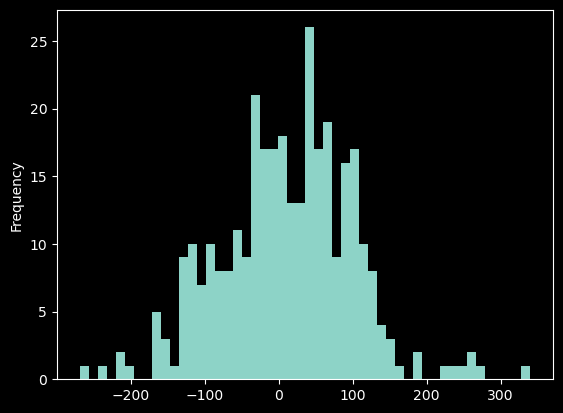

In [6]:
# 可视化dailyPofit分布
dailyPofit['profit'].plot(kind='hist', bins=50)
plt.show()

In [7]:
# 夏普
#dailyPofit['profit'].mean() / dailyPofit['profit'].std() * np.sqrt(252)
dailyPofit['profit'].mean() / dailyPofit['profit'].std() * np.sqrt(totalholdingPeriod/4)

1.3412039125633761

In [8]:
# 均值
dailyPofit['profit'].mean()

10.869898805297733

In [9]:
# 胜率
len(dailyPofit.loc[dailyPofit['profit'] > 0]) / len(dailyPofit)

0.558641975308642

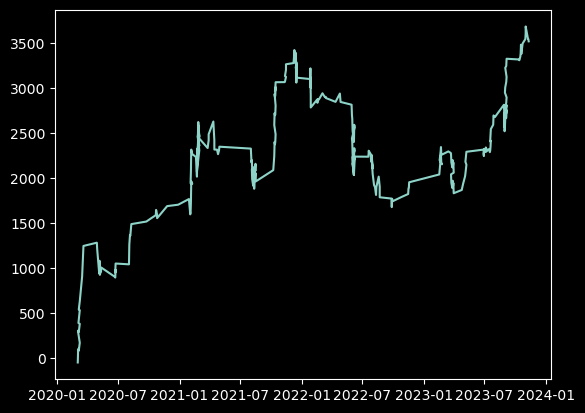

In [10]:
# 累加收益
dailyPofit['cumProfit'] = dailyPofit['profit'].cumsum()

plt.plot(pd.to_datetime(dailyPofit['date']), dailyPofit['cumProfit'])
plt.show()

In [11]:
# 交易次数
len(long50Short300)

95

In [12]:
# 可视化greekProfit组成
profit_delta = dailyPofit['deltaProfit'].sum()
profit_gamma = dailyPofit['gammaProfit'].sum()
profit_vega = dailyPofit['vegaProfit'].sum()
profit_theta = dailyPofit['thetaProfit'].sum()
print('delta:',profit_delta)
print('gamma:',profit_gamma)
print('theta:',profit_theta)
print('vega:',profit_vega)

delta: 644.1753319310583
gamma: -145.46056922732475
theta: -131.47152675799455
vega: 3268.9916538302095


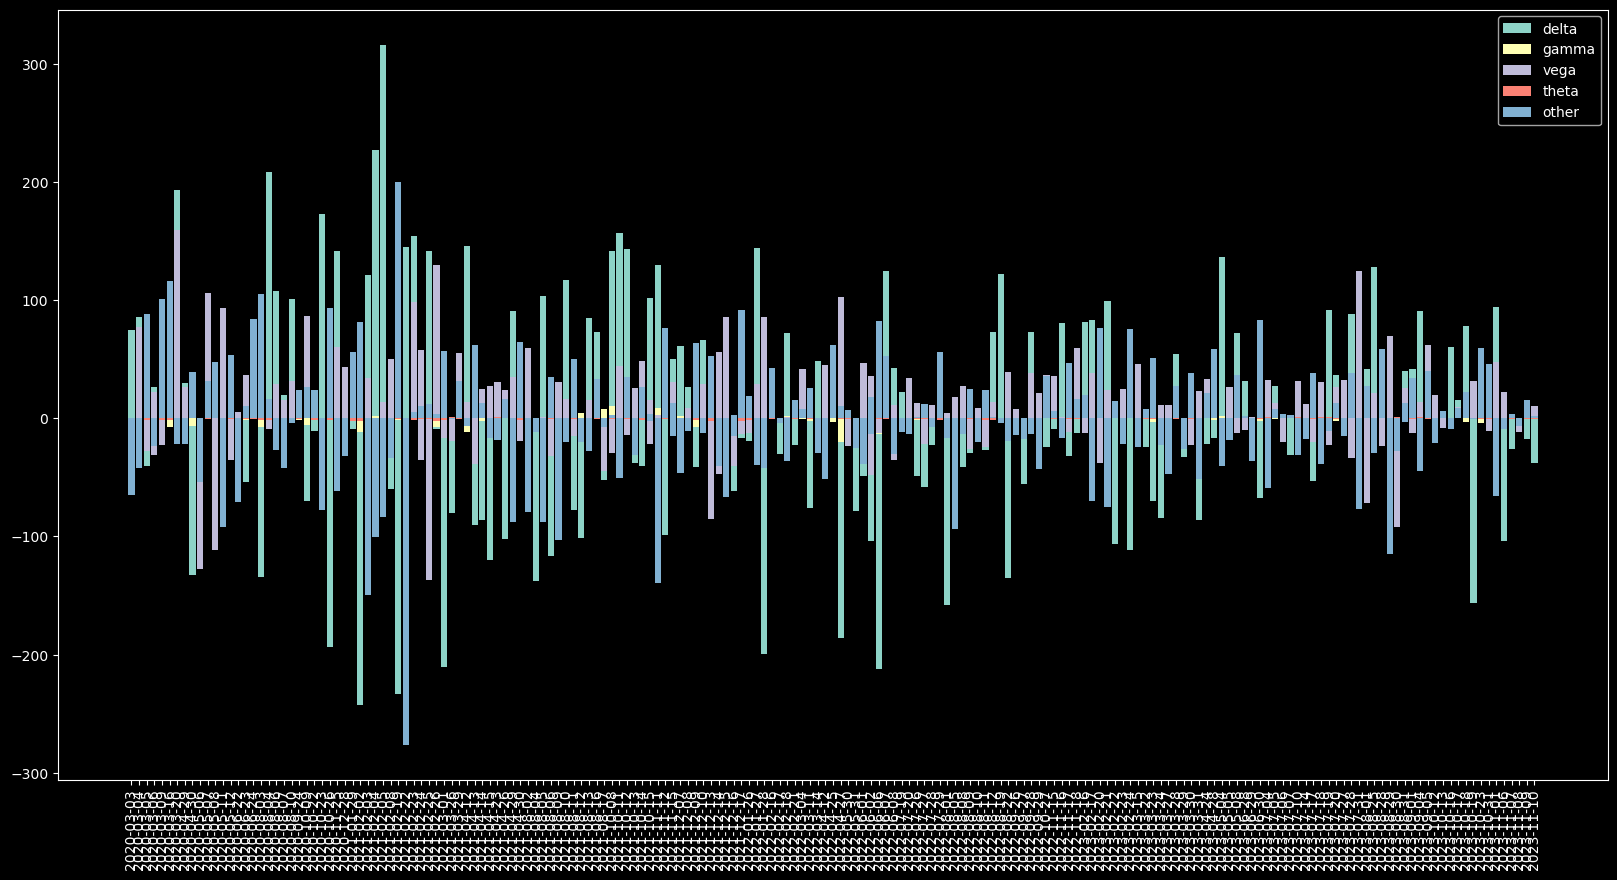

In [13]:
# 柱状图
plt.figure(figsize=(20,10))
plt.bar(dailyPofit['date'], dailyPofit['deltaProfit'], label='delta')
plt.bar(dailyPofit['date'], dailyPofit['gammaProfit'],  label='gamma')
plt.bar(dailyPofit['date'], dailyPofit['vegaProfit'],  label='vega')
plt.bar(dailyPofit['date'], dailyPofit['thetaProfit'],  label='theta')
plt.bar(dailyPofit['date'], dailyPofit['otherProfit'],  label='other')
plt.legend()
plt.xticks(rotation=90)
plt.show()

## long300Short50

### 未考虑持有期内波动

In [14]:
dailyPofit2 = pd.DataFrame()
tradeInfo2 = pd.DataFrame()
totalholdingPeriod2 = 0
# 使用iterrow遍历long300Short50的每一行
for index, row in long300Short50.iterrows():
    # 选出对应日期的etf50和etf300的期权价格
    etf50OptCode = row['OptCode50']
    etf300OptCode = row['OptCode300']
    inDate = row['inDate']
    outDate = row['outDate'].strftime('%Y-%m-%d')
    etf50OptPriceIn = etf50optPrice.loc[(etf50optPrice['datetime'] == inDate)&(etf50optPrice['optionCode'] == etf50OptCode), 'close'].values[0]
    etf50OptPriceOut = etf50optPrice.loc[(etf50optPrice['datetime'] == outDate)&(etf50optPrice['optionCode'] == etf50OptCode), 'close'].values[0]
    etf300OptPriceIn = etf300optPrice.loc[(etf300optPrice['datetime'] == inDate)&(etf300optPrice['optionCode'] == etf300OptCode), 'close'].values[0]
    etf300OptPriceOut = etf300optPrice.loc[(etf300optPrice['datetime'] == outDate)&(etf300optPrice['optionCode'] == etf300OptCode), 'close'].values[0]

    inDelta50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == inDate)&(etf50OptRisk['optionCode'] == etf50OptCode), 'delta'].values[0]
    inUnd50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == inDate)&(etf50OptRisk['optionCode'] == etf50OptCode), 'underlying_price'].values[0]
    inDelta300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == inDate)&(etf300OptRisk['optionCode'] == etf300OptCode), 'delta'].values[0]
    inUnd300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == inDate)&(etf300OptRisk['optionCode'] == etf300OptCode), 'underlying_price'].values[0]

    cashDelta50 = inDelta50 * inUnd50
    cashDelta300 = inDelta300 * inUnd300

    share50 = -10000
    share300 = abs(share50 * cashDelta50 / cashDelta300)

    # 计算收益
    profit = share50 * (etf50OptPriceOut - etf50OptPriceIn) + share300 * (etf300OptPriceOut - etf300OptPriceIn)
    # 交易成本结算
    commission = 2 * 1.7 * (abs(share50) + abs(share300)) / 10000
    slppage = 2 * 0.0001 * 0 * (abs(share50) + abs(share300))

    holdingPeriod = (pd.to_datetime(outDate) - pd.to_datetime(inDate)).days
    totalholdingPeriod2 += holdingPeriod

    print('date: ', outDate, 'profit: ', profit,'holding period:',holdingPeriod)
    dailyPofit2 = pd.concat([dailyPofit2, pd.DataFrame({'date': [outDate], 'profit': [profit-commission-slppage]})], ignore_index=True)

dailyProfit2 = dailyPofit2.groupby('date').sum().reset_index()

date:  2020-02-20 profit:  295.3994093271423 holding period: 8
date:  2020-02-20 profit:  258.30430434486277 holding period: 7
date:  2020-03-23 profit:  38.30058832210872 holding period: 3
date:  2020-04-08 profit:  96.87092226110079 holding period: 13
date:  2020-04-08 profit:  145.50926586694368 holding period: 12
date:  2020-04-08 profit:  172.18241780917066 holding period: 8
date:  2020-04-08 profit:  105.70181505682491 holding period: 6
date:  2020-04-20 profit:  3.3603447075282418 holding period: 7
date:  2020-04-20 profit:  -57.454347668759624 holding period: 6
date:  2020-04-20 profit:  -65.65268831807667 holding period: 4
date:  2020-06-02 profit:  156.61966085447307 holding period: 5
date:  2020-06-02 profit:  128.12779192189947 holding period: 4
date:  2020-06-08 profit:  2.999674936257115 holding period: 3
date:  2020-07-16 profit:  464.5507107661765 holding period: 10
date:  2020-07-16 profit:  338.4198851718812 holding period: 9
date:  2020-08-17 profit:  191.38820921488

### 考虑持有期内波动

In [15]:
dailyPofit2 = pd.DataFrame()
tradeInfo2 = pd.DataFrame()
# 使用iterrow遍历long300Short50的每一行
for index, row in long300Short50.iterrows():
    # 选出对应日期的etf50和etf300的期权价格
    etf50OptCode = row['OptCode50']
    etf300OptCode = row['OptCode300']
    inDate = row['inDate']
    outDate = row['outDate'].strftime('%Y-%m-%d')
    
    inDelta50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == inDate)&(etf50OptRisk['optionCode'] == etf50OptCode), 'delta'].values[0]
    inUnd50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == inDate)&(etf50OptRisk['optionCode'] == etf50OptCode), 'underlying_price'].values[0]
    inDelta300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == inDate)&(etf300OptRisk['optionCode'] == etf300OptCode), 'delta'].values[0]
    inUnd300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == inDate)&(etf300OptRisk['optionCode'] == etf300OptCode), 'underlying_price'].values[0]

    cashDelta50 = inDelta50 * inUnd50
    cashDelta300 = inDelta300 * inUnd300

    share50 = -10000
    share300 = abs(share50 * cashDelta50 / cashDelta300)

    # 交易成本结算
    commission = 2 * 1.7 * (abs(share50) + abs(share300)) / 10000
    slppage = 2 * 0.0001 * 0 * (abs(share50) + abs(share300))

    dateList = etf50optPrice.loc[(etf50optPrice['datetime'] >= inDate)&(etf50optPrice['datetime'] <= outDate)&(etf50optPrice['optionCode'] == etf50OptCode), 'datetime'].tolist()
    # 遍历inDate到outtDate之间的每一天
    for date in dateList:
        if date.strftime('%Y-%m-%d') == outDate:
            continue

        today = date.strftime('%Y-%m-%d')
        # 计算下一个交易日,实际上就是dateList的下一个date
        tomorrow = dateList[dateList.index(date) + 1].strftime('%Y-%m-%d')
                
        etf50OptPriceIn = etf50optPrice.loc[(etf50optPrice['datetime'] == today)&(etf50optPrice['optionCode'] == etf50OptCode), 'close'].values[0]
        etf50OptPriceOut = etf50optPrice.loc[(etf50optPrice['datetime'] == tomorrow)&(etf50optPrice['optionCode'] == etf50OptCode), 'close'].values[0]
        etf300OptPriceIn = etf300optPrice.loc[(etf300optPrice['datetime'] == today)&(etf300optPrice['optionCode'] == etf300OptCode), 'close'].values[0]
        etf300OptPriceOut = etf300optPrice.loc[(etf300optPrice['datetime'] == tomorrow)&(etf300optPrice['optionCode'] == etf300OptCode), 'close'].values[0]

        delta50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == today)&(etf50OptRisk['optionCode'] == etf50OptCode), 'delta'].values[0]
        delta300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == today)&(etf300OptRisk['optionCode'] == etf300OptCode), 'delta'].values[0]
        gamma50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == today)&(etf50OptRisk['optionCode'] == etf50OptCode), 'gamma'].values[0]
        gamma300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == today)&(etf300OptRisk['optionCode'] == etf300OptCode), 'gamma'].values[0]
        vega50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == today)&(etf50OptRisk['optionCode'] == etf50OptCode), 'vega'].values[0]
        vega300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == today)&(etf300OptRisk['optionCode'] == etf300OptCode), 'vega'].values[0]
        theta50 = etf50OptRisk.loc[(etf50OptRisk['datetime'] == today)&(etf50OptRisk['optionCode'] == etf50OptCode), 'theta'].values[0]
        theta300 = etf300OptRisk.loc[(etf300OptRisk['datetime'] == today)&(etf300OptRisk['optionCode'] == etf300OptCode), 'theta'].values[0]

        und50In = etf50OptRisk.loc[(etf50OptRisk['datetime'] == today)&(etf50OptRisk['optionCode'] == etf50OptCode), 'underlying_price'].values[0]
        und300In = etf300OptRisk.loc[(etf300OptRisk['datetime'] == today)&(etf300OptRisk['optionCode'] == etf300OptCode), 'underlying_price'].values[0]
        und50Out = etf50OptRisk.loc[(etf50OptRisk['datetime'] == tomorrow)&(etf50OptRisk['optionCode'] == etf50OptCode), 'underlying_price'].values[0]
        und300Out = etf300OptRisk.loc[(etf300OptRisk['datetime'] == tomorrow)&(etf300OptRisk['optionCode'] == etf300OptCode), 'underlying_price'].values[0]

        iv50In = etf50OptRisk.loc[(etf50OptRisk['datetime'] == today)&(etf50OptRisk['optionCode'] == etf50OptCode), 'iv'].values[0]
        iv300In = etf300OptRisk.loc[(etf300OptRisk['datetime'] == today)&(etf300OptRisk['optionCode'] == etf300OptCode), 'iv'].values[0]
        iv50Out = etf50OptRisk.loc[(etf50OptRisk['datetime'] == tomorrow)&(etf50OptRisk['optionCode'] == etf50OptCode), 'iv'].values[0]
        iv300Out = etf300OptRisk.loc[(etf300OptRisk['datetime'] == tomorrow)&(etf300OptRisk['optionCode'] == etf300OptCode), 'iv'].values[0]

        # 计算收益
        profit = share50 * (etf50OptPriceOut - etf50OptPriceIn) + share300 * (etf300OptPriceOut - etf300OptPriceIn)
        if date == inDate:
            profit = profit - commission - slppage
        
        # 收益分解
        dt = -1/244
        deltaProfit = share50 * (und50Out - und50In) * delta50 + share300 * (und300Out - und300In) * delta300
        gammaProfit = 0.5 * share50 * (und50Out - und50In) ** 2 * gamma50 + 0.5 * share300 * (und300Out - und300In) ** 2 * gamma300
        vegaProfit = share50 * (iv50Out - iv50In) * vega50 + share300 * (iv300Out - iv300In) * vega300
        thetaProfit = share50 * theta50 * dt + share300 * theta300 * dt
        greekProfit = deltaProfit + gammaProfit + vegaProfit + thetaProfit
        otherProfit = profit - greekProfit

        print('date: ', tomorrow, 'profit: ', profit,'greekProfit: ', greekProfit, 'error:', otherProfit/profit*100)
        print('deltaProfit: ', deltaProfit, 'gammaProfit: ', gammaProfit, 'vegaProfit: ', vegaProfit, 'thetaProfit: ', thetaProfit)

        dailyPofit2 = pd.concat([dailyPofit2, pd.DataFrame({'date': [tomorrow], 'profit': [profit],'greekProfit':[thetaProfit],'deltaProfit':[deltaProfit],'gammaProfit':[gammaProfit],'vegaProfit':[vegaProfit],'thetaProfit':[thetaProfit],'otherProfit':[otherProfit]})], ignore_index=True)
        tradeInfo = pd.concat([tradeInfo, pd.DataFrame({'date':date,'option 50 code':etf50OptCode,'option 300 code':etf300OptCode,'share 50':share50,'share 300':share300,'etf50 option price':etf50OptPriceIn,'etf300 option price':etf300OptPriceIn,\
            'delta 50':delta50,'delta 300':delta300,'gamma 50':gamma50,'gamma 300':gamma300,'vega 50':vega50,'vega 300':vega300,'theta 50':theta50,'theta 300':theta300,'und 50':und50In,'und 300':und300In,'iv 50':iv50In,'iv 300':iv300In},index=[0])], ignore_index=True)
dailyProfit2 = dailyPofit2.groupby('date').sum().reset_index()

date:  2020-02-13 profit:  12.65064637255869 greekProfit:  -22.60467876572416 error: 278.6839826205038
deltaProfit:  -6.923409815559495 gammaProfit:  0.20807209560781537 vegaProfit:  -16.223231059070763 thetaProfit:  0.3338900132982836
date:  2020-02-14 profit:  62.53457000905054 greekProfit:  39.36204935288478 error: 37.0555368859369
deltaProfit:  21.107838161048832 gammaProfit:  0.6551288635420003 vegaProfit:  17.288190543596468 thetaProfit:  0.3108917846974846
date:  2020-02-17 profit:  107.60414806028547 greekProfit:  47.08104692869299 error: 56.24606692456157
deltaProfit:  60.80924156513498 gammaProfit:  5.436423931589669 vegaProfit:  -19.569431932662795 thetaProfit:  0.4048133646311296
date:  2020-02-18 profit:  28.4584997918529 greekProfit:  97.71008038509896 error: -243.3423444656468
deltaProfit:  41.24252606404603 gammaProfit:  -1.5326274745391002 vegaProfit:  57.60385002825919 thetaProfit:  0.3963317673328399
date:  2020-02-19 profit:  -12.298229935051491 greekProfit:  -3.070

In [16]:
tradeInfo.to_excel('long300Short50TradeInfo.xlsx',index=False)
dailyPofit2.to_excel('long300Short50DailyProfit.xlsx',index=False)

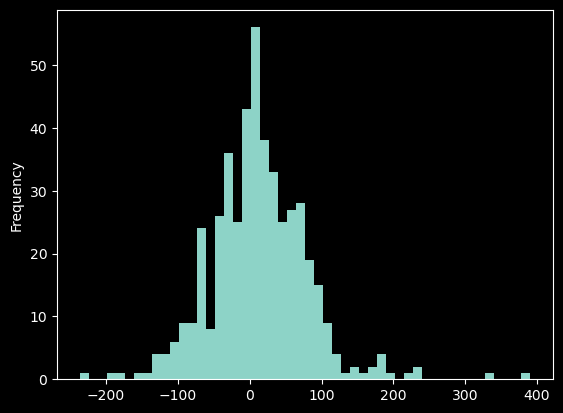

In [17]:
dailyPofit2['deltaProfit'].plot(kind='hist', bins=50)

### 策略评估

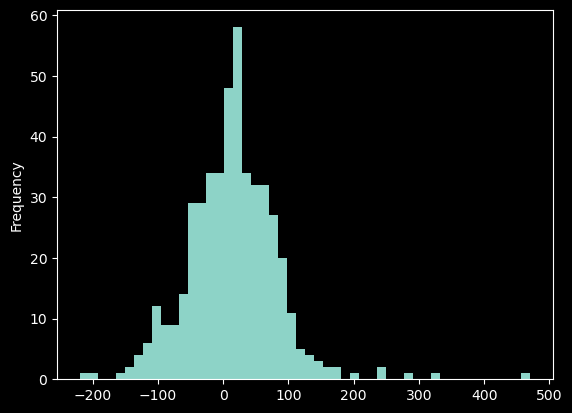

In [18]:
# 可视化dailyPofit2分布，正态拟合
dailyPofit2['profit'].plot(kind='hist', bins=50)
plt.show()

In [19]:
# 夏普
#dailyPofit2['profit'].mean() / dailyPofit2['profit'].std() * np.sqrt(252)
dailyPofit2['profit'].mean() / dailyPofit2['profit'].std() * np.sqrt(totalholdingPeriod2/4)

2.701213860101731

In [20]:
# 均值
dailyPofit2['profit'].mean()

14.034214189207447

In [21]:
# 胜率
len(dailyPofit2.loc[dailyPofit2['profit'] > 0]) / len(dailyPofit2)

0.6119402985074627

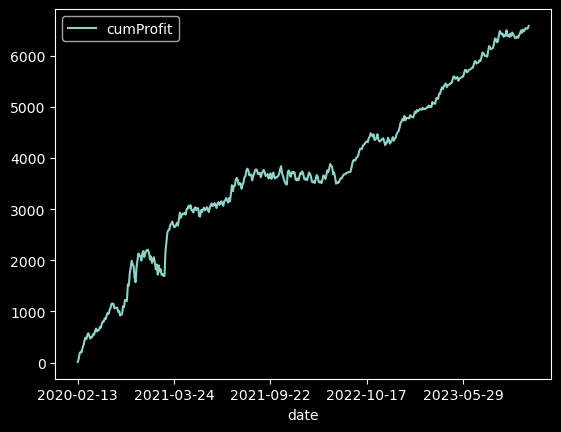

In [22]:
# 累加收益
dailyPofit2['cumProfit'] = dailyPofit2['profit'].cumsum()

dailyPofit2.plot(x='date', y='cumProfit')
plt.show()

In [23]:
# 交易次数
len(long300Short50)

103

In [24]:
# 可视化greekProfit组成
profit_delta = dailyPofit2['deltaProfit'].sum()
profit_gamma = dailyPofit2['gammaProfit'].sum()
profit_vega = dailyPofit2['vegaProfit'].sum()
profit_theta = dailyPofit2['thetaProfit'].sum()
print('delta:',profit_delta)
print('gamma:',profit_gamma)
print('theta:',profit_theta)
print('vega:',profit_vega)

delta: 5913.1182488964605
gamma: -3.3070444716626355
theta: 23.59526469148222
vega: 2529.464193104525


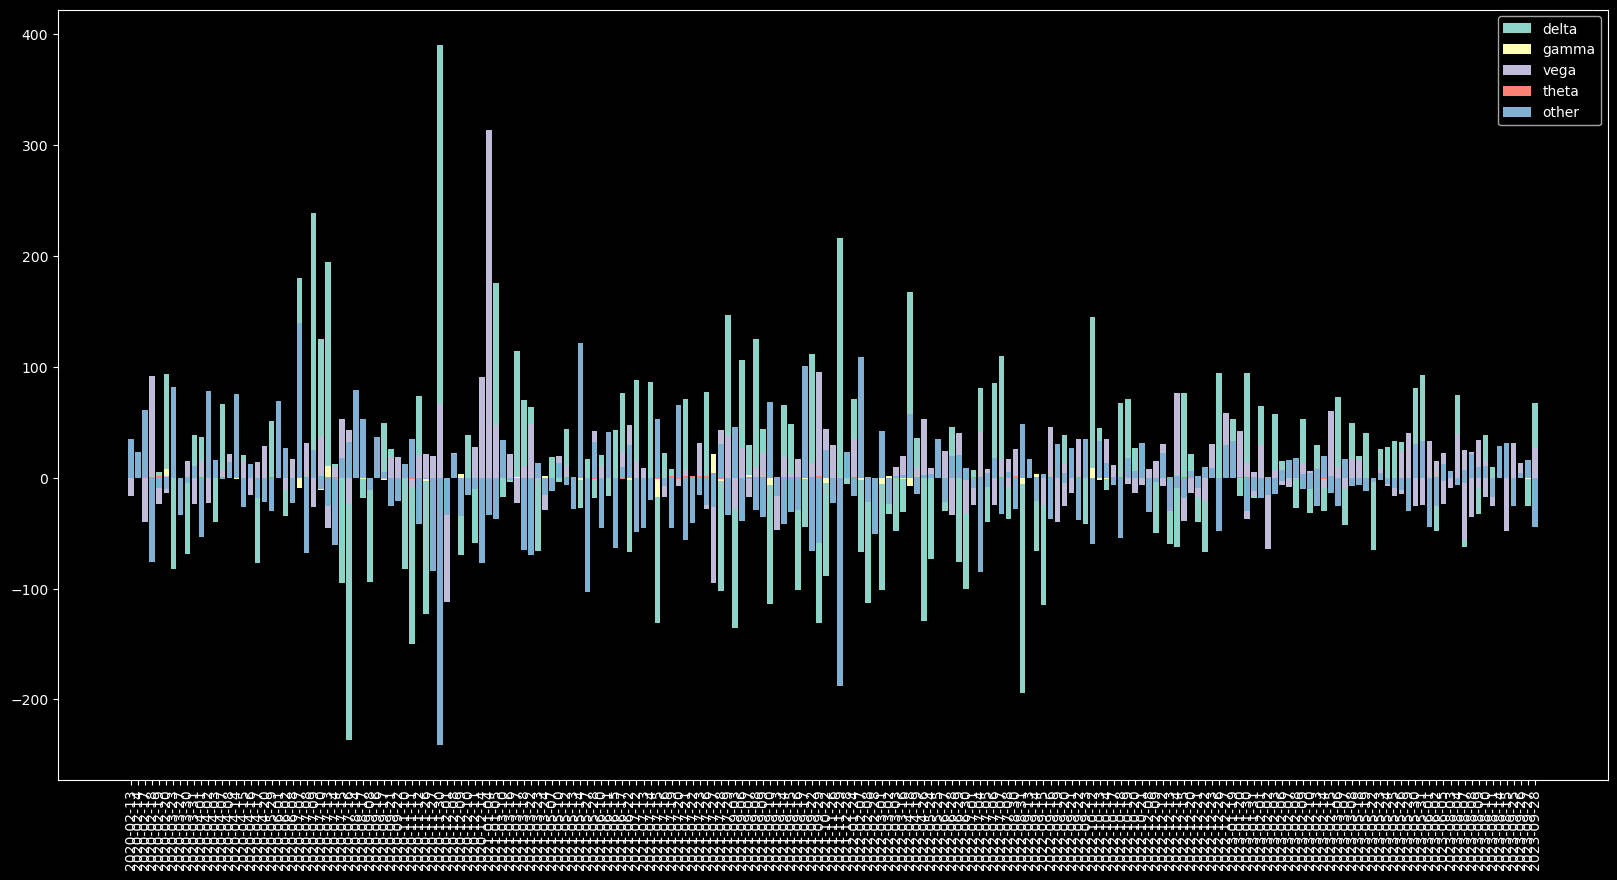

In [25]:
# 柱状图
plt.figure(figsize=(20,10))
plt.bar(dailyPofit2['date'], dailyPofit2['deltaProfit'], label='delta')
plt.bar(dailyPofit2['date'], dailyPofit2['gammaProfit'],  label='gamma')
plt.bar(dailyPofit2['date'], dailyPofit2['vegaProfit'],  label='vega')
plt.bar(dailyPofit2['date'], dailyPofit2['thetaProfit'],  label='theta')
plt.bar(dailyPofit2['date'], dailyPofit2['otherProfit'],  label='other')
plt.legend()
plt.xticks(rotation=90)
plt.show()

## generate

In [26]:
# 合并dailyPofit和dailyPofit2
dailyProfitTotal = pd.concat([dailyPofit[['date','profit']], dailyPofit2[['date','profit']]], ignore_index=True)
# 日期重复的收益合并
dailyProfitTotal = dailyProfitTotal.groupby('date').sum().reset_index()
dailyProfitTotal

,date,profit
0,2020-02-13,12.650646
1,2020-02-14,111.691529
2,2020-02-17,197.524570
3,2020-02-18,88.606204
4,2020-02-19,-38.959245
...,...,...
381,2023-11-06,-97.925095
382,2023-11-07,-21.150413
383,2023-11-08,-19.936971
384,2023-11-09,-0.917019


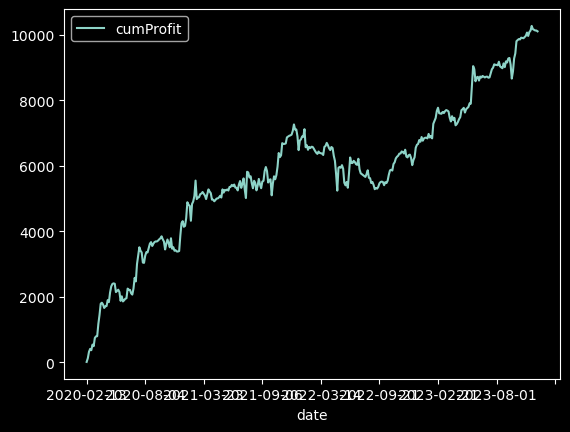

In [27]:
# 累计收益
dailyProfitTotal['cumProfit'] = dailyProfitTotal['profit'].cumsum()

dailyProfitTotal.plot(x='date', y='cumProfit')
plt.show()

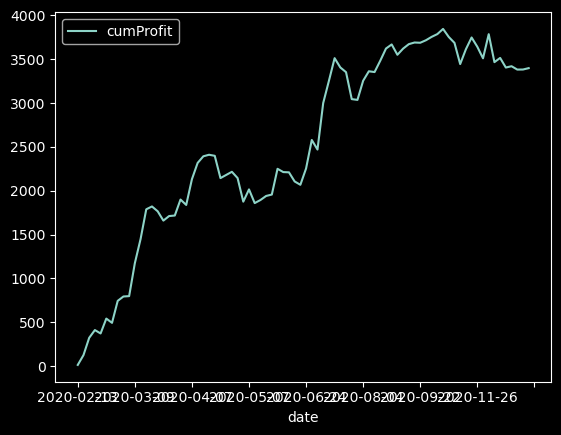

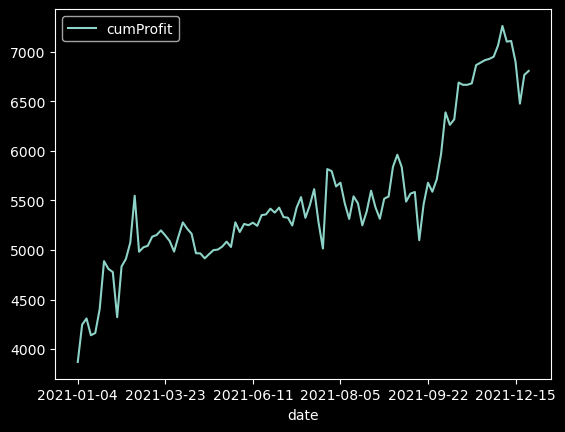

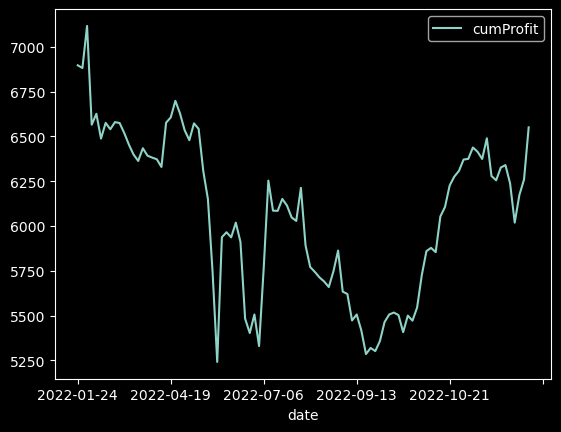

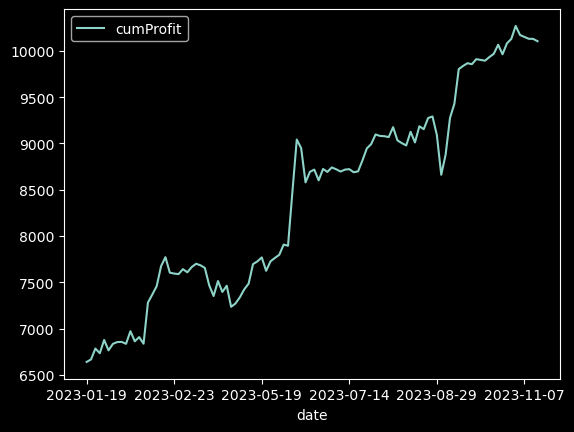

In [28]:
# 将dailyProfitTotal按年份分开并分别可视化走势，横轴为datetime
dailyProfitTotal['year'] = pd.to_datetime(dailyProfitTotal['date']).dt.year
# 按年份分组
dailyProfitTotal.groupby('year').plot(x='date', y='cumProfit')
plt.show()

In [29]:
dailyProfitTotal['addCapitalProfit'] = dailyProfitTotal['cumProfit'] + 100000
# return 
dailyProfitTotal['return'] = dailyProfitTotal['addCapitalProfit'].pct_change()
# sharp ratio
dailyProfitTotal['return'].mean() / dailyProfitTotal['return'].std() * np.sqrt(252)

2.3901449746753696

In [30]:
# 最大回撤样例代码
'''
apital_df['cummax'] = capital_df['capital'].cummax()
capital_df['drawdown'] = (capital_df['capital'] / capital_df['cummax']) - 1
max_drawdown = capital_df['drawdown'].min() * 100 
'''
# 最大回撤
dailyProfitTotal['cummax'] = dailyProfitTotal['addCapitalProfit'].cummax()
dailyProfitTotal['drawdown'] = (dailyProfitTotal['addCapitalProfit'] / dailyProfitTotal['cummax']) - 1
max_drawdown = dailyProfitTotal['drawdown'].min() * 100
max_drawdown

-1.8840947775229488

In [31]:
# winning ratio
len(dailyProfitTotal.loc[dailyProfitTotal['return'] > 0]) / len(dailyProfitTotal)

0.5647668393782384